In [1]:
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# extra
import wrf

# import personal modules
# Path to modules
sys.path.append('../modules')

# Import my modules
from wrf_funcs_preprocess import select_single_coord_WRF
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date

In [3]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/nash/DATA/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)

In [14]:
arname = ['jan2002', 'feb2010']
dslst_singlecoord = []
rain_lst = []
freeze_lst = []

for j, ar in enumerate(arname):
    
    # import configuration file for case study choice
    yaml_doc = '../data/ar_casestudy.yml'
    config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
    ar_dict = config[ar]
    wrf_filenames = ar_dict['wrf_files']
    start_date = ar_dict['start_date']
    end_date = add_days_to_date(ar_dict['end_date'], 1)
    print(start_date, end_date)
    year = ar_dict['year']

    dates = pd.date_range(start_date, end_date, freq='3H')
    
    ## Open WRF data and get single coordinate vertical data
    varlst = ('pressure', 'theta', 'theta_e', 'ua', 'va', 'wa', 'td', 'tc', 'z', 'QVAPOR', 'HGT')
    ds_lst = []
    for i, pt in enumerate(ptlst):
        ds = select_single_coord_WRF(wrf_filenames, varlst, pt[1], pt[0], dates.values)

        # calculate specific humidity from mixing ratio (units: kg kg-1)
        ds = ds.assign(q=lambda ds: np.divide(ds.QVAPOR, (1+ds.QVAPOR)))

        # compute vertical moisture flux (units: m s-1*kg kg-1)
        uq = ds.ua*ds.q
        vq = ds.va*ds.q
        ds = ds.assign(wvf=lambda ds: np.sqrt(uq**2 + vq**2))
        ds_lst.append(ds)
    dslst_singlecoord.append(ds_lst)
    
    ## Now get WRF 2D data
    domain = ['d02', 'd02']
    varname_lst = ['prec', 'sr']
    res_lst = ['3hr', '3hr']

    ## loop through each ds
    ds_lst1 = []
    for i, (dom, varname, res) in enumerate(zip(domain, varname_lst, res_lst)):
        if server == 'great':
            data_path = path_to_data + 'wrf_hasia/'
        else:
            data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start_date, end_date))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        # if varname == 'prec':
        #     # Calculate precipitation rate
        #     ds = ds.shift(time=-1) - ds # if in xarray

        ds_lst1.append(ds)
    
    
    ## select the data at the point location
    rain_rte = []
    freeze = []
    for i, pt in enumerate(ptlst):
        # Calculate precipitation rate
        rain = ds_lst1[0].sel(lat=pt[1], lon=pt[0], method='nearest')
        rrate = rain.shift(time=-1) - rain # if in xarray
        rain_rte.append(rrate)
        # get fraction of frozen precipitation
        freeze.append(ds_lst1[1].sel(lat=pt[1], lon=pt[0], method='nearest'))
    rain_lst.append(rain_rte)
    freeze_lst.append(freeze)
   

2002-01-10 2002-01-14
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  0
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  1
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  2
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  3
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  4
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  5
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  6
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  7
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  8
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  9
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  10
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  11
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  12
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  13
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  14
/home/hasia/2001/wrfout_d02_2002-01-10_03:0

## Time x height plots

In [69]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# to do: set this to the point lat/lon 
row_lbl = []
for i, pt in enumerate(ptlst):
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}E".format(pt[1], pt[0])
    row_lbl.append(lbl)

print(row_lbl)

### Get x-tick and x-labels for both cases
x1 = rain_lst[0][0].time.values
x2 = rain_lst[1][0].time.values

x_lst = [x1, x2]
xlbl_lst = []
xtick_lst = []
for i, x in enumerate(x_lst):
    x_lbl = []
    xtick_lst.append(x)
    for j in range(len(x)):
        t = pd.to_datetime(str(x[j]))
        x_lbl.append(t.strftime('%m-%d %H'))
    xlbl_lst.append(x_lbl)
    
# point location for (a) (b) (c) label annotation
xpt = 0.02
ypt = 0.80
ypt2 = 0.975

['35.18°N, 72.82°E', '33.73°N, 74.82°E']


nan nan
nan nan
nan nan
nan nan


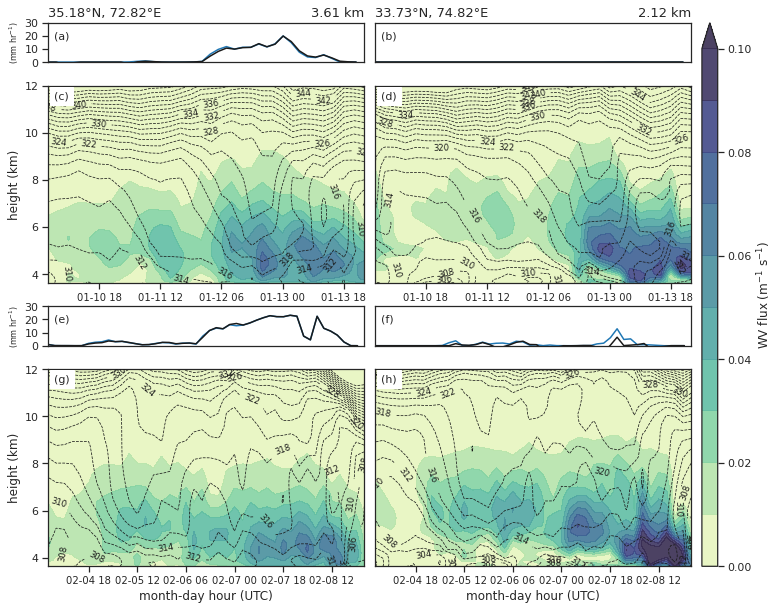

In [70]:
filepath = path_to_figs + 'time_height.png'
nrows = len(ds_lst)*2 # number of "station" locations
ncols = 3 # two time x height plots plus colorbar

# Create figure
fig = plt.figure(figsize=(12, len(ds_lst)*5))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[0.2, 1, 0.2, 1], width_ratios = [1, 1, 0.05], wspace=0.05, hspace=0.2)
## use gs[rows index, columns index] to access grids

##########################
### Plot Jan 2002 case ###
##########################
ttl = ['(a)', '(b)']
## precipitation time series
for k, data in enumerate(rain_lst[0]):
    ax = fig.add_subplot(gs[0, k])
    # WRF Precip
    x = data.prec.time.values
    y = data.prec.values
    print(y.min(), y.max())
    ax.plot(x, y, color='tab:blue')

    # WRF SNOW
    y = data.snow.values
    ax.plot(x, y, color='k')
    
    # some plot parameters to make it look nice
    ax.set_ylim(0, 30)
    ax.set_yticks(np.arange(0, 35, 10))
    ax.set_xlim(x.min(), x.max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    
    if k == 0:
        ax.set_ylabel('(mm hr$^{-1}$)', fontsize=8)
        # y_dates = ys.strftime('%m-%d %H').sort_values().unique()
        # ax.set_yticklabels(labels=y_dates, rotation=0)
    if k > 0:
        ax.get_yaxis().set_ticks([])
    
    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)
    loc_hgt = ds_lst[k].HGT.values.max()/1000.0 # height of gridcell amsl
    ax.set_title('{:.2f} km'.format(loc_hgt), loc='right',fontsize=13)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

ttl = ['(c)', '(d)']
### Plot time x height
for k, data in enumerate(dslst_singlecoord[0]):
    ax = fig.add_subplot(gs[1, k])

    # Contour Filled
    wvf = data.wvf.values
    xs = np.repeat(data.Time.values, data.height.values.shape[1]).reshape(data.height.values.shape)
    ys = data.height.values/1000. # height axis converted to km
    cflevs = np.arange(0, 0.11, 0.01)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(xs, ys, wvf, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')
    
    # thetaE contours
    clevs = np.arange(270, 350, 2)
    cs = ax.contour(xs, ys, data.theta_e.values, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # parameters to make plot pretty
    ax.set_ylim(ys.min(), 12)
    
    
    ## x-axis format dates/ticks
    x_ticks = xtick_lst[0]
    x_labels = xlbl_lst[0]
    ax.set_xticks(x_ticks[::6]) # set the labels every 12 hours
    ax.set_xticklabels(x_labels[::6], fontsize=10)
    ax.set_xlim(xs.min(), xs.max())
    if k == 0:
        ax.set_ylabel('height (km)')
    if k > 0:
        ax.get_yaxis().set_ticks([])
        
    # add text title
    ax.text(xpt, ypt2, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

        
##########################
### Plot Feb 2010 case ###
##########################

## precipitation time series
ttl = ['(e)', '(f)']
for k, data in enumerate(rain_lst[1]):
    ax = fig.add_subplot(gs[2, k])
    # WRF Precip
    x = data.prec.time.values
    y = data.prec.values
    print(y.min(), y.max())
    ax.plot(x, y, color='tab:blue')

    # WRF SNOW
    y = data.snow.values
    ax.plot(x, y, color='k')
    
    # some plot parameters to make it look nice
    ax.set_ylim(0, 30)
    ax.set_yticks(np.arange(0, 35, 10))
    ax.set_xlim(x.min(), x.max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    
    if k == 0:
        ax.set_ylabel('(mm hr$^{-1}$)', fontsize=8)
        # y_dates = ys.strftime('%m-%d %H').sort_values().unique()
        # ax.set_yticklabels(labels=y_dates, rotation=0)
    if k > 0:
        ax.get_yaxis().set_ticks([])
        
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
### Plot time x height
ttl = ['(g)', '(h)']
for k, data in enumerate(dslst_singlecoord[1]):
    ax = fig.add_subplot(gs[3, k])

    # Contour Filled
    wvf = data.wvf.values
    xs = np.repeat(data.Time.values, data.height.values.shape[1]).reshape(data.height.values.shape)
    ys = data.height.values/1000. # height axis converted to km
    cflevs = np.arange(0, 0.11, 0.01)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(xs, ys, wvf, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')
    
    # thetaE contours
    clevs = np.arange(270, 350, 2)
    cs = ax.contour(xs, ys, data.theta_e.values, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # parameters to make plot pretty
    ax.set_ylim(ys.min(), 12)
    
    if k == 0:
        ax.set_ylabel('height (km)')
    if k > 0:
        ax.get_yaxis().set_ticks([])
    
    ## x-axis format dates/ticks
    x_ticks = xtick_lst[1]
    x_labels = xlbl_lst[1]
    ax.set_xticks(x_ticks[::6]) # set the labels every 12 hours
    ax.set_xticklabels(x_labels[::6], fontsize=10)
    ax.set_xlim(xs.min(), xs.max())
    # add x-axis label to this bottom row
    ax.set_xlabel('month-day hour (UTC)')
    
    # add text title
    ax.text(xpt, ypt2, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
# Add color bar
cbax = plt.subplot(gs[:,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('WV flux (m$^{-1}$ s$^{-1}$)')

    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
